In [7]:
!pip install psycopg2-binary


import numpy as np  # numpy için farklı bir isim
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 1.4 MB/s eta 0:00:0000:0100:010m


In [12]:
import psycopg2 as ps

try:
    conn = ps.connect(
        dbname='capstone_project',  # Veritabanı adı
        user='postgres',             # Kullanıcı adı
        password='1234',            # Şifre
        host='localhost',           # Host
        port='5432'                 # PostgreSQL varsayılan portu
    )
    print("Bağlantı başarılı!")
except Exception as e:
    print("Bağlantı hatası:", e)




Bağlantı başarılı!


In [43]:
## Neden RFM Analizi Yaptım?

##RFM analizi yapmamın amacı, müşterilerimin satın alma davranışlarını daha iyi anlayarak onları farklı segmentlere ayırmak ve bu sayede hedefli pazarlama stratejileri geliştirmektir.
##Müşteri bağlılığını artırmak, yüksek değerli müşterileri tanımlamak ve kaybetme riski olan müşterilere yönelik geri kazanma stratejileri oluşturmak için RFM analizini kullanıyorum.


In [18]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps

# Veritabanına bağlantı sağlama
try:
    conn = ps.connect(
        dbname='capstone_project',
        user='postgres',
        password='1234',
        host='localhost',
        port='5432'
    )
    print("Bağlantı başarılı!")

    # Örnek SQL sorgusu
    query = """WITH recency AS (
    SELECT o.customer_id,
           MAX(o.order_date) AS max_order_date,
           '1998-05-06'::date - MAX(o.order_date) AS days_since_last_order
    FROM orders o
    WHERE o.shipped_date IS NOT NULL
    GROUP BY o.customer_id
),
frequency AS (
    SELECT o.customer_id,
           COUNT(o.order_id) AS order_frequency
    FROM orders o
    WHERE o.shipped_date IS NOT NULL
    GROUP BY o.customer_id
),
monetary AS (
    SELECT o.customer_id,
           SUM(od.unit_price * od.quantity) AS monetary
    FROM orders o
    JOIN order_details od ON o.order_id = od.order_id
    WHERE o.shipped_date IS NOT NULL
    GROUP BY o.customer_id
),
rfm AS (
    SELECT COALESCE(r.customer_id, f.customer_id, m.customer_id) AS customer_id,
           COALESCE(r.days_since_last_order, 0) AS days_since_last_order,
           COALESCE(f.order_frequency, 0) AS order_frequency,
           COALESCE(m.monetary, 0) AS monetary
    FROM recency r
    FULL OUTER JOIN frequency f ON r.customer_id = f.customer_id
    FULL OUTER JOIN monetary m ON r.customer_id = m.customer_id
),
rfm_scores AS (
    SELECT customer_id,
           CASE 
               WHEN days_since_last_order <= 30 THEN 5
               WHEN days_since_last_order <= 60 THEN 4
               WHEN days_since_last_order <= 90 THEN 3
               WHEN days_since_last_order <= 120 THEN 2
               ELSE 1
           END AS recency_score,
           CASE 
               WHEN order_frequency >= 10 THEN 5
               WHEN order_frequency >= 5 THEN 4
               WHEN order_frequency >= 3 THEN 3
               WHEN order_frequency >= 1 THEN 2
               ELSE 1
           END AS frequency_score,
           CASE 
               WHEN monetary >= 1000 THEN 5
               WHEN monetary >= 500 THEN 4
               WHEN monetary >= 100 THEN 3
               WHEN monetary >= 50 THEN 2
               ELSE 1
           END AS monetary_score
    FROM rfm
),
rfm_segments AS (
    SELECT customer_id,
           recency_score,
           frequency_score,
           monetary_score,
           (recency_score + frequency_score + monetary_score) AS total_score,
           CASE 
               WHEN (recency_score + frequency_score + monetary_score) >= 12 THEN 'VIP Customer'
               WHEN (recency_score + frequency_score + monetary_score) >= 9 THEN 'Loyal Customer'
               WHEN (recency_score + frequency_score + monetary_score) >= 6 THEN 'New Customer'
               ELSE 'At Risk Customer'
           END AS segment
    FROM rfm_scores
)
SELECT *
FROM rfm_segments
ORDER BY total_score DESC;"""  # Gerçek tablo adını yazmalısınız
    df = sqlio.read_sql_query(query, conn)
    
    # DataFrame'i görüntüleme
    print(df)

except Exception as e:
    print("Hata:", e)

finally:
    # Bağlantıyı kapatma
    if conn is not None:
        conn.close()
        print("Bağlantı kapatıldı.")


Bağlantı başarılı!
   customer_id  recency_score  frequency_score  monetary_score  total_score  \
0        PICCO              5                5               5           15   
1        ERNSH              5                5               5           15   
2        SUPRD              5                5               5           15   
3        REGGC              5                5               5           15   
4        OLDWO              5                5               5           15   
..         ...            ...              ...             ...          ...   
84       HUNGC              1                4               5           10   
85       LAUGB              1                3               4            8   
86       GROSR              1                2               5            8   
87       CENTC              1                2               3            6   
88       LAZYK              1                2               3            6   

           segment  
0     VIP C

/var/folders/3j/6dxlknmd5hs82yqpxtj2n3z00000gn/T/ipykernel_2968/3280766064.py:91: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(query, conn)


In [19]:

df.head()

,customer_id,recency_score,frequency_score,monetary_score,total_score,segment
0,PICCO,5,5,5,15,VIP Customer
1,ERNSH,5,5,5,15,VIP Customer
2,SUPRD,5,5,5,15,VIP Customer
3,REGGC,5,5,5,15,VIP Customer
4,OLDWO,5,5,5,15,VIP Customer


In [20]:
df.shape

(89, 6)

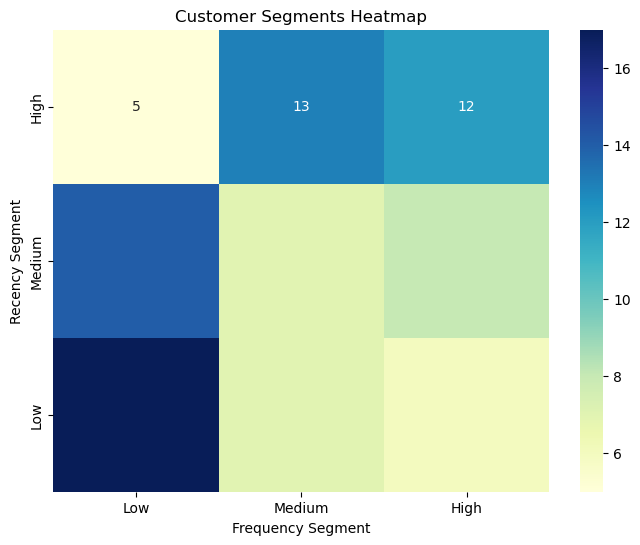

In [28]:
# Segmenting the data
df['R_Segment'] = pd.qcut(df['days_since_last_order'], 3, labels=['High', 'Medium', 'Low'])
df['F_Segment'] = pd.qcut(df['order_frequency'], 3, labels=['Low', 'Medium', 'High'])
df['M_Segment'] = pd.qcut(df['monetary'], 3, labels=['Low', 'Medium', 'High'])

# Creating a pivot table
pivot_table = df.pivot_table(index='R_Segment', columns='F_Segment', values='customer_id', aggfunc='count', fill_value=0)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Customer Segments Heatmap')
plt.xlabel('Frequency Segment')
plt.ylabel('Recency Segment')
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


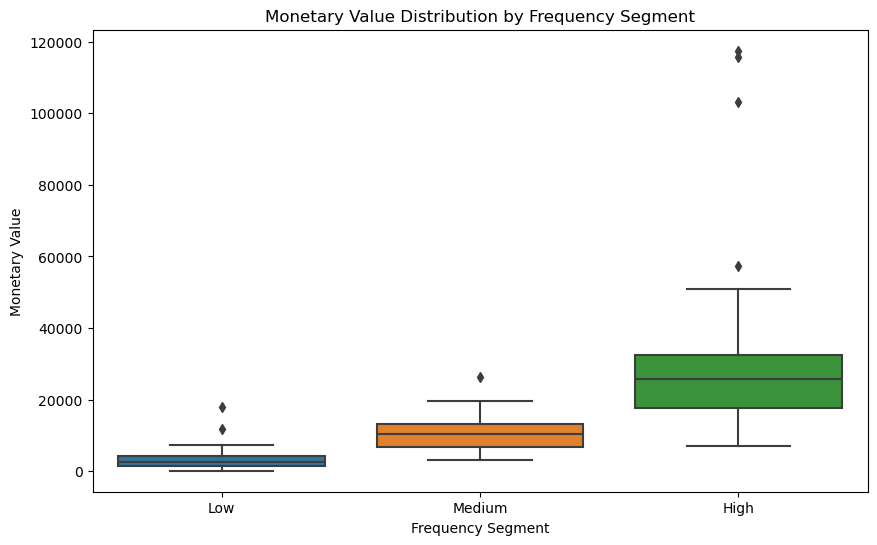

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='F_Segment', y='monetary', data=df)
plt.title('Monetary Value Distribution by Frequency Segment')
plt.xlabel('Frequency Segment')
plt.ylabel('Monetary Value')
plt.show()


/var/folders/3j/6dxlknmd5hs82yqpxtj2n3z00000gn/T/ipykernel_2968/2092270192.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = df.groupby('F_Segment').agg({'monetary': 'mean', 'order_frequency': 'mean', 'days_since_last_order': 'mean'}).reset_index()


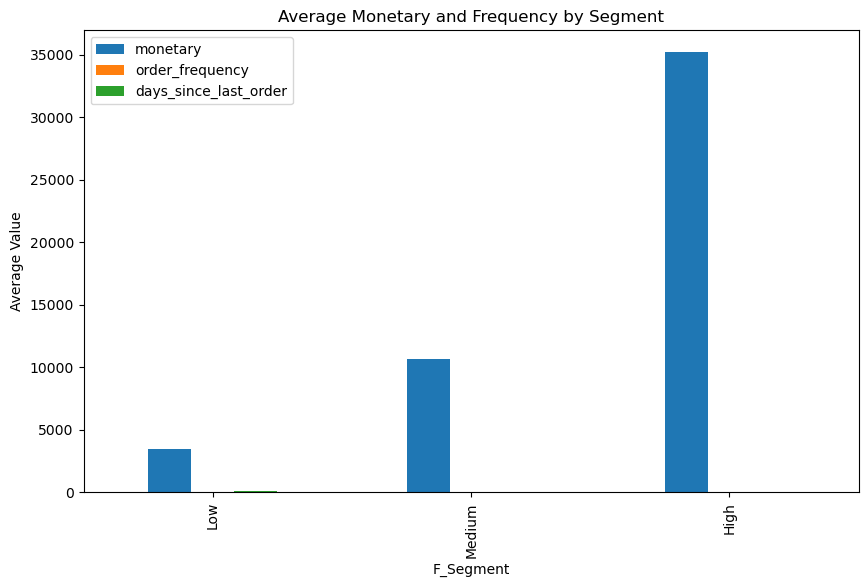

In [30]:
summary_df = df.groupby('F_Segment').agg({'monetary': 'mean', 'order_frequency': 'mean', 'days_since_last_order': 'mean'}).reset_index()

summary_df.plot(x='F_Segment', kind='bar', figsize=(10, 6))
plt.title('Average Monetary and Frequency by Segment')
plt.ylabel('Average Value')
plt.show()


In [44]:
##Bu SQL sorgusunu, ürünlerin belirli yıllar ve aylarda ne kadar gelir elde ettiğini analiz etmek için yazdım. 
##Hedefim, her bir ürünün gelir performansını zamana göre incelemek, en çok gelir getiren ürünleri belirlemek ve hangi zaman dilimlerinde bu ürünlerin daha fazla satıldığını görmek. Bu analiz, satış trendlerini anlamama, stok yönetimini optimize etmeme ve daha stratejik pazarlama kararları almama yardımcı olacaktır.


In [38]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps

# Veritabanına bağlantı sağlama
conn = None
try:
    conn = ps.connect(
        dbname='capstone_project',
        user='postgres',
        password='1234',
        host='localhost',
        port='5432'
    )
    print("Bağlantı başarılı!")

    query = """SELECT 
        p.product_name, 
        EXTRACT(YEAR FROM o.order_date) AS order_year,
        EXTRACT(MONTH FROM o.order_date) AS order_month,
        ROUND(SUM(od.unit_price * od.quantity)::numeric, 2) AS product_revenue
    FROM 
        order_details od
    JOIN 
        products p ON od.product_id = p.product_id
    JOIN 
        orders o ON od.order_id = o.order_id
    GROUP BY 
        p.product_name, order_year, order_month
    ORDER BY 
        product_revenue DESC;"""

    # Veritabanından sorguyu çekme
    df = sqlio.read_sql_query(query, conn)
    
    # DataFrame'i görüntüleme
    print(df)

except Exception as e:
    print("Hata:", e)

finally:
    # Bağlantıyı kapatma
    if conn is not None:
        conn.close()
        print("Bağlantı kapatıldı.")


Bağlantı başarılı!
                   product_name  order_year  order_month  product_revenue
0                 Côte de Blaye      1998.0          2.0         26350.00
1                 Côte de Blaye      1997.0          1.0         20869.20
2       Thüringer Rostbratwurst      1998.0          2.0         20301.56
3                 Côte de Blaye      1998.0          1.0         18445.00
4          Raclette Courdavault      1998.0          4.0         17710.00
...                         ...         ...          ...              ...
1157  Louisiana Hot Spiced Okra      1998.0          5.0            17.00
1158                    Geitost      1996.0         10.0            16.00
1159                   Filo Mix      1998.0          5.0            14.00
1160                      Konbu      1997.0          1.0             9.60
1161                      Konbu      1997.0          3.0             4.80

[1162 rows x 4 columns]
Bağlantı kapatıldı.


/var/folders/3j/6dxlknmd5hs82yqpxtj2n3z00000gn/T/ipykernel_2968/2747894559.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(query, conn)


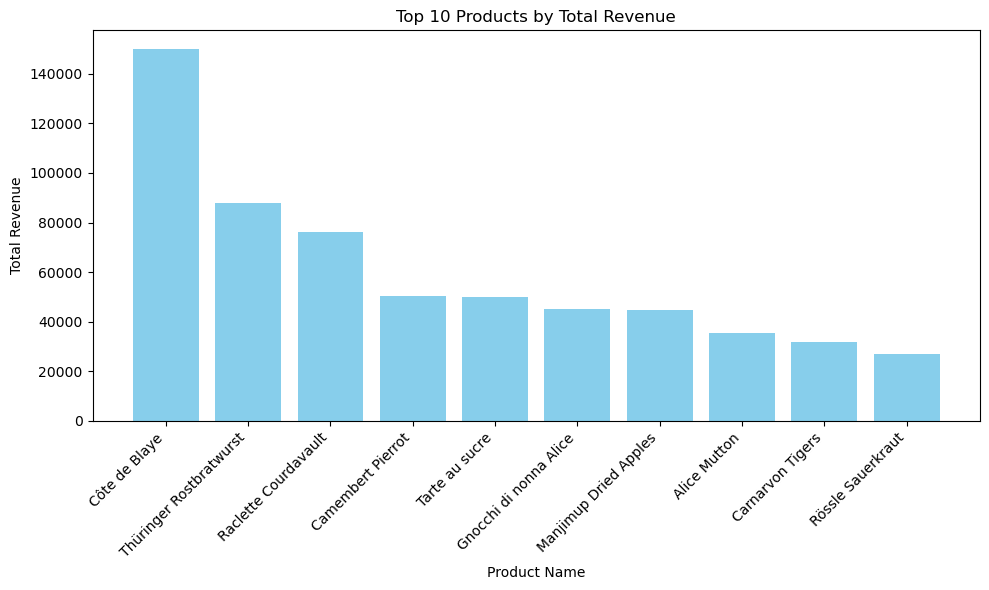

In [40]:
import matplotlib.pyplot as plt

# Ürünlerin toplam gelirine göre sıralanmış ilk 10 ürünü seçelim
top_products = df.groupby('product_name')['product_revenue'].sum().nlargest(10).reset_index()

# Bar grafiği çizelim
plt.figure(figsize=(10, 6))
plt.bar(top_products['product_name'], top_products['product_revenue'], color='skyblue')
plt.title('Top 10 Products by Total Revenue')
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


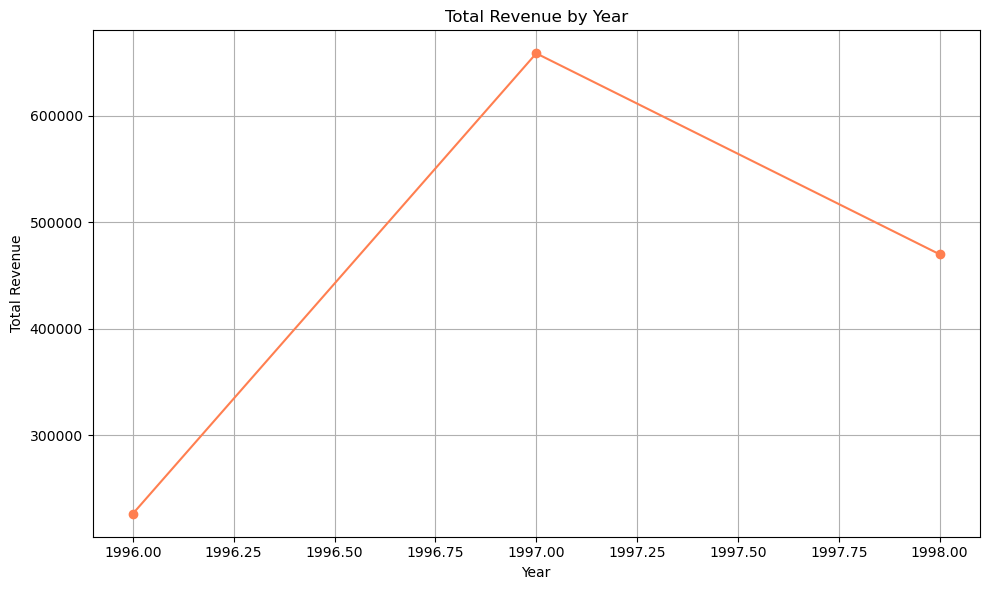

In [41]:
# Yıllık toplam geliri hesaplayalım
yearly_revenue = df.groupby('order_year')['product_revenue'].sum().reset_index()

# Çizgi grafiği çizelim
plt.figure(figsize=(10, 6))
plt.plot(yearly_revenue['order_year'], yearly_revenue['product_revenue'], marker='o', linestyle='-', color='coral')
plt.title('Total Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()
